In [191]:
import pandas as pd
from numpy import nan, mean, median
from statistics import mode
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# Home Data pipeline

See [readme](../README.md) 2do section for next steps

In [192]:
# load data

global training___data, validation_data, training___price, validation_price, full_data, full_price, test_data, original_data, original_test_data
def load_data():
    global training___data, validation_data, training___price, validation_price, full_data, full_price, test_data, original_data, original_test_data
    test_data = pd.read_csv("./test.csv")
    original_test_data = test_data.copy()
    original_data = pd.read_csv("./train.csv")
    full_price = original_data.SalePrice
    training___data, validation_data, training___price, validation_price = train_test_split(original_data, full_price)
    training___data = training___data.drop("SalePrice", axis=1)
    validation_data = validation_data.drop("SalePrice", axis=1)
    full_data = original_data.drop("SalePrice", axis=1)

load_data()
training___data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
22,23,20,RL,75.0,9742,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,1Story,8,5,2002,2002,Hip,CompShg,VinylSd,VinylSd,BrkFace,281.0,Gd,TA,PConc,Gd,TA,No,Unf,0,Unf,0,1777,1777,GasA,Ex,Y,SBrkr,1795,0,0,1795,0,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2002.0,RFn,2,534,TA,TA,Y,171,159,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
922,923,20,RL,65.0,10237,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,RRAn,Norm,1Fam,1Story,6,5,2005,2006,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,28,Unf,0,1288,1316,GasA,Ex,Y,SBrkr,1316,0,0,1316,0,0,2,0,3,1,Gd,6,Typ,1,Gd,Attchd,2005.0,Fin,2,397,TA,TA,Y,100,0,0,23,0,0,NaN,NaN,NaN,0,10,2006,New,Partial
1250,1251,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065,Unf,0,1045,2110,GasA,Ex,Y,SBrkr,2110,0,0,2110,1,0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2,522,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
37,38,20,RL,74.0,8532,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1954,1990,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,650.0,TA,TA,CBlock,TA,TA,No,Rec,1213,Unf,0,84,1297,GasA,Gd,Y,SBrkr,1297,0,0,1297,0,1,1,0,3,1,TA,5,Typ,1,TA,Attchd,1954.0,Fin,2,498,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,10,2009,WD,Normal
644,645,20,FV,85.0,9187,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,9,5,2009,2009,Gable,CompShg,CemntBd,CmentBd,Stone,162.0,Ex,TA,PConc,Ex,TA,Mn,GLQ,1121,Unf,0,645,1766,GasA,Ex,Y,SBrkr,1766,0,0,1766,1,0,2,1,2,1,Ex,7,Typ,1,Gd,Attchd,2009.0,Fin,3,478,TA,TA,Y,195,130,0,0,0,0,NaN,NaN,NaN,0,10,2009,New,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,1108,60,RL,168.0,23257,Pave,NaN,IR3,HLS,AllPub,CulDSac,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,Gd,TA,PConc,Ex,Gd,No,Unf,0,Unf,0,868,868,GasA,Ex,Y,SBrkr,887,1134,0,2021,0,0,2,1,3,1,Gd,9,Typ,1,Gd,BuiltIn,2006.0,RFn,2,422,TA,TA,Y,0,100,0,0,0,0,NaN,NaN,NaN,0,9,2006,New,Partial
1350,1351,90,RL,91.0,11643,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Artery,Norm,Duplex,2Story,5,5,1969,1969,Gable,CompShg,MetalSd,MetalSd,BrkFace,368.0,TA,TA,CBlock,TA,TA,No,LwQ,500,Unf,0,748,1248,GasA,TA,Y,SBrkr,1338,1296,0,2634,1,1,2,2,6,2,TA,12,Typ,0,NaN,Detchd,1969.0,Unf,4,968,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2009,WD,Normal
312,313,190,RM,65.0,7800,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,2fmCon,1.5Fin,5,7,1939,1950,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Mn,Rec,507,Unf,0,286,793,GasA,TA,Y,SBrkr,793,325,0,1118,1,0,1,0,3,1,TA,5,Typ,1,Gd,Detchd,1939.0,Unf,2,410,TA,TA,Y,0,0,0,0,271,0,NaN,MnPrv,NaN,0,5,2006,WD,Normal
326,327,120,RL,32.0,10846,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Veenker,Norm,Norm,TwnhsE,1Story,8,5,1993,1993,Gable,CompShg,BrkFace,BrkFace,NaN,0.0,Gd,TA,PConc,Gd,TA,Gd,GLQ,1619,Unf,0,100,1719,GasA,Ex,Y,SBrkr,1719,0,0,1719,2,0,1,1,1,1,Gd,6,

In [193]:
full_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,TA,TA,Mn,GLQ,49,Rec,1029,0,1078,GasA,Gd,Y,FuseA,1078,0,0,1078,1,0,1,0,2,1,Gd,5,Typ,0,NaN,Attchd,1950.0,Unf,1,2

In [194]:
# define possible column transformations

is_nan = lambda x: x != x
equals = lambda a, b: (is_nan(a) and is_nan(b)) or a == b
all_unique_values = lambda column_name: set(training___data[column_name].unique()) | set(validation_data[column_name].unique())
all_non_nan_values = lambda column_name: set(training___data[column_name].dropna().unique()) | set(validation_data[column_name].dropna().unique())

def drop(column_name, data_set, *_):
    data_set.drop(column_name, axis=1, inplace=True)
    return data_set

def drop_row(column_name, data_set, condition):
    return data_set[~data_set[column_name].apply(condition)]

def one_hot(column_name, data_set, options):
    keys = options if options else data_set[column_name].unique()
    for key in keys:
        data_set[f"{column_name}_{key}"] = data_set[column_name].apply(lambda x: 1 if equals(x, key) else 0)
    return drop(column_name, data_set)

def apply(column_name, data_set, function):
    data_set[column_name] = data_set[column_name].apply(function)
    return data_set

def re_map(column_name, data_set, mapping):
    data_set[column_name] = data_set[column_name].apply(lambda x: mapping[x])
    return data_set

def impute(column_name, data_set, function):
    imputation = function(data_set[column_name])
    data_set[column_name] = data_set[column_name].apply(lambda x: imputation if is_nan(x) else x)
    return data_set

def MSZoning(column_name, data_set, *_):
    options = dict(
        # A="Agriculture",
        C="Commercial",
        FV="Floating Village Residential",
        # I="Industrial",
        RH="Residential High Density",
        RL="Residential Low Density",
        # RP="Residential Low Density Park",
        RM="Residential Medium Density",
    )
    for key, name in options.items():
        if key == "C":
            continue
        data_set[f"zoned_{name}"] = data_set[column_name].apply(lambda x: 1 if x in [key, "C"] else 0)
    return drop(column_name, data_set)

def neighborhood_median(column_name, data_set, *_):
    neighborhood_medians = training___data[[column_name, "Neighborhood"]].groupby("Neighborhood").median().to_dict()[column_name]
    fn = lambda x: neighborhood_medians[x["Neighborhood"]] if is_nan(x[column_name]) else x[column_name]
    data_set[column_name] = data_set.apply(fn, axis=1)
    return data_set

def PoolQC(column_name, data_set, *_):
    remap = {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1}
    def fn(x):
        if x[column_name] in remap:
            return remap[x[column_name]]
        if not is_nan(x["PoolArea"]):
            return 1 + (x["OverallQual"]-1)*3/9
        return 0
    data_set[column_name] = data_set.apply(fn, axis=1)
    return data_set

def masonry(column_name, data_set, *_):
    options = dict(
        BrkCmn="Brick Common",
        BrkFace="Brick Face",
        CBlock="Cinder Block",
        Stone="Stone",
    )
    for key in options:
        data_set[f"masonry {options[key]}"] = 0
        for id in range(len(data_set)):
            if data_set[column_name].iloc[id] == key:
                value = data_set["MasVnrArea"].iloc[id]
                # ideally set the above set to the average of that type in that neighborhood (instead of the guess of 75)
                data_set[f"masonry {options[key]}"].iat[id] = value if value > 2 else 75
    
    data_set[f"masonry other"] = 0
    for id in range(len(data_set)):
        if is_nan(data_set["MasVnrType"].iloc[id]) and data_set["MasVnrArea"].iloc[id] > 2:
            data_set["masonry other"].iat[id] = data_set["MasVnrArea"].iloc[id]

    data_set.drop(["MasVnrType", "MasVnrArea"], axis=1, inplace=True)
    return data_set

def fix_basement(data_set):
    basement_fields = [b for b in test_data.keys() if "Bsmt" in b]
    for row_id, row in data_set[basement_fields].iterrows():
        any_nulls = row.isnull().any()
        non_nulls = [type(i) == str for i in row]
        non_zeros = [i > 0 if type(i) in [float, int] else False for key, i in row.items()]
        if any_nulls and (any(non_nulls) or any(non_zeros)):
            for key, i in row.items():
                if is_nan(i):
                    data_set.at[row_id, key] = mode(data_set[key].dropna())

def basement(column_name, data_set, *_):
    fix_basement(data_set)
    options = dict(
        GLQ="Good Living Quarters",
        ALQ="Average Living Quarters",
        BLQ="Below Average Living Quarters",
        Rec="Average Rec Room",
        LwQ="Low Quality",
        Unf="Unfinished",
    )
    for key in options:
        data_set[f"basement {options[key]} sqft"] = 0
        for id in range(len(data_set)):
            if data_set["BsmtFinType1"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF1"].iloc[id]
            if data_set["BsmtFinType2"].iloc[id] == key:
                data_set[f"basement {options[key]} sqft"].iat[id] += data_set["BsmtFinSF2"].iloc[id]
    
    data_set.drop(["BsmtFinType1", "BsmtFinSF1", "BsmtFinType2", "BsmtFinSF2"], axis=1, inplace=True)
    return data_set

def basement_unfinished(column_name, data_set, *_):
    unf1 = "basement Unfinished sqft"
    unf2 = "BsmtUnfSF"
    data_set[unf1] = data_set.apply(lambda x: x[unf1] + x[unf2], axis=1)
    
    data_set.drop(["BsmtUnfSF"], axis=1, inplace=True)
    return data_set

def garage_year(column_name, data_set, *_):
    data_set["GarageYrBlt"] = data_set.apply(lambda x: x["YearBuilt"] if is_nan(x["GarageYrBlt"]) else x["GarageYrBlt"], axis=1)
    return data_set

def NA_to_zero(column_name, data_set, *_):
    data_set[column_name] = data_set[column_name].apply(lambda x: 0 if is_nan(x) else x)
    return data_set

def bathz(column_name, data_set, *_):
    cols = ["BsmtFullBath", "FullBath", "BsmtHalfBath", "HalfBath"]
    for col in cols:
        data_set = NA_to_zero(col, data_set)
    data_set[column_name] = data_set["BsmtFullBath"] + data_set["FullBath"] + 0.5*(data_set["BsmtHalfBath"] + data_set["HalfBath"])
    data_set.drop(cols, axis=1, inplace=True)
    return data_set

def is_new(column_name, data_set, *_):
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YrSold"] == x["YearBuilt"] else 0, axis=1)
    return data_set

def age(column_name, data_set, *_):
    data_set[column_name] = data_set.apply(lambda x: x["YrSold"] - x["YearRemodAdd"], axis=1)
    return data_set

def remodeled(column_name, data_set, *_):
    data_set[column_name] = data_set.apply(lambda x: 1 if x["YearBuilt"] != x["YearRemodAdd"] else 0, axis=1)
    return data_set

hoods = original_data[["SalePrice", "Neighborhood"]].groupby("Neighborhood").mean().sort_values("SalePrice").index.tolist()
def hood_check(i):
    if i < 3:
        return 0
    if i >= len(original_data["Neighborhood"].unique()) - 3:
        return 2
    return 1
bougieness = {hood: hood_check(i) for i, hood in enumerate(hoods)}

def total_sqft(column_name, data_set, *_):
    data_set[column_name] = data_set["TotalBsmtSF"] + data_set["GrLivArea"]
    data_set.drop(["TotalBsmtSF"], axis=1, inplace=True)
    return data_set

import inflation
def sale_price(column_name, data_set, *_):
    if column_name in data_set:
        for id in range(len(data_set)):
            data_set[column_name].iat[id] = inflation.adjust(
                price = data_set[column_name].iloc[id],
                from_year = data_set["YrSold"].iloc[id],
                from_month = data_set["MoSold"].iloc[id],
                to_year = 2010,
                to_month = 7,
            )
    data_set.drop(["MoSold", "YrSold"], axis=1, inplace=True)
    return data_set

def post_process(results, data_set, root_data):
    # global original_data
    output = []
    for id, price in enumerate(results):
        id_original = data_set["Id"].iloc[id]
        new_price = inflation.adjust(
            price=price,
            from_year=2010,
            from_month=7,
            to_year=int(root_data["YrSold"][root_data["Id"] == id_original].iloc[0]),
            to_month=int(root_data["MoSold"][root_data["Id"] == id_original].iloc[0]),
        )
        output.append(new_price)
    return results

In [195]:
# specify each column transformation

transformations = [
    ("MSSubClass", (one_hot, all_unique_values("MSSubClass"))),
    ("MSZoning", (impute, mode)),
    ("MSZoning", (MSZoning, None)),
    ("LotFrontage", (neighborhood_median, None)),
    ("Street", (re_map, {"Pave": 1, "Grvl": 0})),
    ("Alley", (drop, None)),
    ("LotShape", (re_map, {"Reg": 0, "IR1": 1, "IR2": 2, "IR3": 3})),
    # "LandContour": (re_map, {"Lvl": 1, "Bnk": 3, "HLS": 2, "Low": 0}),
    ("LandContour", (one_hot, all_unique_values("LandContour"))),
    ("Utilities", (drop, None)),
    ("LotConfig", (one_hot, all_unique_values("LotConfig"))),
    ("LandSlope", (re_map, {"Gtl": 2, "Mod": 1, "Sev": 0})),
    ("Neighborhood", (re_map, bougieness)),
    ("Condition1", (one_hot, all_unique_values("Condition1"))),
    ("Condition2", (one_hot, all_unique_values("Condition2"))),
    ("BldgType", (one_hot, all_unique_values("BldgType"))),
    ("HouseStyle", (one_hot, all_unique_values("HouseStyle"))),
    ("RoofStyle", (one_hot, all_unique_values("RoofStyle"))),
    ("RoofMatl", (one_hot, all_unique_values("RoofMatl"))),
    ("Exterior1st", (impute, mode)),
    ("Exterior1st", (one_hot, all_unique_values("Exterior1st"))),
    ("Exterior2nd", (drop, None)),
    ("MasVnrType", (masonry, None)),
    ("ExterQual", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("ExterCond", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("Foundation", (one_hot, all_unique_values("Foundation"))),
    ("TotalBsmtSF", (NA_to_zero, None)),
    ("BsmtUnfSF", (NA_to_zero, None)),
    ("TotalBsmtSF", (basement, None)),
    ("BsmtQual", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("BsmtCond", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("BsmtExposure", (re_map, {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0, nan: 0})),
    ("BsmtUnfSF", (basement_unfinished, None)),
    ("bathz", (bathz, None)),
    ("Heating", (one_hot, all_unique_values("Heating"))),
    ("HeatingQC", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("CentralAir", (re_map, {"Y": 1, "N": 0})),
    ("Electrical", (re_map, {"SBrkr": 4, "FuseA": 3, "FuseF": 2, "FuseP": 1, "Mix": 0, nan: 0})),
    ("KitchenQual", (impute, mode)),
    ("KitchenQual", (re_map, {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "Po": 0})),
    ("Functional", (impute, mode)),
    ("Functional", (re_map, {"Typ": 7, "Min1": 6, "Min2": 5, "Mod": 4, "Maj1": 3, "Maj2": 2, "Sev": 1, "Sal": 0})),
    ("FireplaceQu", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, nan: 0})),
    ("GarageType", (one_hot, all_non_nan_values("GarageType"))),
    ("GarageYrBlt", (garage_year, None)),
    ("GarageFinish", (re_map, {"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0, nan: 0})),
    ("GarageCars", (NA_to_zero, None)),
    ("GarageQual", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("GarageCond", (re_map, {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0, nan: 0})),
    ("PavedDrive", (re_map, {"Y": 2, "P": 1, "N": 0})),
    ("PoolQC", (PoolQC, None)),
    ("Fence", (one_hot, all_unique_values("Fence"))),
    ("MiscFeature", (drop, None)),
    ("SaleType", (impute, mode)),
    ("SaleType", (one_hot, all_unique_values("SaleType"))),
    ("SaleCondition", (one_hot, all_unique_values("SaleCondition"))),
    ("Age", (age, None)),
    ("IsNew", (is_new, None)),
    ("YrSold", (one_hot, all_unique_values("YrSold"))),
    ("MoSold", (one_hot, all_unique_values("MoSold"))),
    ("YearBuilt", (drop, None)),
    ("YearRemodAdd", (drop, None)),
    ("TotalSqft", (total_sqft, None)),
]

In [196]:
def manual_transformations():
    for col in ["GarageFinish", "GarageQual", "GarageCond"]:
        test_data[col].iat[666] = mode(test_data[col])
    test_data["GarageType"].iat[1116] = nan
    test_data["GarageArea"].iat[1116] = 0

In [197]:
# apply column transformations to data
load_data()
for column_name, (transform, option) in transformations:
    print("transforming", column_name)
    training___data = transform(column_name, training___data, option)
    validation_data = transform(column_name, validation_data, option)

validation_data

transforming MSSubClass
transforming MSZoning
transforming MSZoning
transforming LotFrontage
transforming Street
transforming Alley
transforming LotShape
transforming LandContour
transforming Utilities
transforming LotConfig
transforming LandSlope
transforming Neighborhood
transforming Condition1
transforming Condition2
transforming BldgType
transforming HouseStyle
transforming RoofStyle
transforming RoofMatl
transforming Exterior1st
transforming Exterior1st
transforming Exterior2nd
transforming MasVnrType
transforming ExterQual
transforming ExterCond
transforming Foundation
transforming TotalBsmtSF
transforming BsmtUnfSF
transforming TotalBsmtSF
transforming BsmtQual
transforming BsmtCond
transforming BsmtExposure
transforming BsmtUnfSF
transforming bathz
transforming Heating
transforming HeatingQC
transforming CentralAir
transforming Electrical
transforming KitchenQual
transforming KitchenQual
transforming Functional
transforming Functional
transforming FireplaceQu
transforming Garag

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_Low,LandContour_HLS,LandContour_Lvl,LandContour_Bnk,LotConfig_FR2,LotConfig_FR3,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Corner,Condition1_Norm,Condition1_PosN,Condition1_RRNn,Condition1_RRNe,Condition1_PosA,Condition1_RRAe,Condition1_Artery,Condition1_Feedr,Condition1_RRAn,Condition2_Norm,Condition2_PosN,Condition2_RRNn,Condition2_PosA,Condition2_RRAe,Condition2_Artery,Condition2_Feedr,Condition2_RRAn,BldgType_Duplex,BldgType_Twnhs,BldgType_2fmCon,BldgType_TwnhsE,BldgType_1Fam,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_2.5Fin,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Hip,RoofStyle_Shed,RoofStyle_Gambrel,RoofMatl_Roll,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_ClyTile,RoofMatl_Metal,RoofMatl_WdShngl,Exterior1st_CBlock,Exterior1st_Wd Sdng,Exterior1st_Stone,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_Plywood,Exterior1st_ImStucc,Exterior1st_WdShing,Exterior1st_AsphShn,Exterior1st_AsbShng,masonry Brick Common,masonry Brick Face,masonry Cinder Block,masonry Stone,masonry other,Foundation_Slab,Foundation_CBlock,Foundation_Wood,Foundation_Stone,Foundation_BrkTil,Foundation_PConc,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_Wall,Heating_OthW,Heating_Grav,Heating_GasA,Heating_Floor,Heating_GasW,GarageType_BuiltIn,GarageType_Detchd,GarageType_CarPort,GarageType_Basment,GarageType_2Types,GarageType_Attchd,Fence_MnPrv,Fence_MnWw,Fence_GdPrv,Fence_nan,Fence_GdWo,SaleType_ConLI,SaleType_WD,SaleType_New,SaleType_Con,SaleType_COD,SaleType_Oth,SaleType_CWD,SaleType_ConLw,SaleType_ConLD,SaleCondition_Alloca,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Family,SaleCondition_Abnorml,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
772,773,94.0,7819,1,0,2,1,6,5,2,2,3,3,3,2,1,4,1117,0,0,1117,3,1,2,6,7,1,3,1976.0,1,2,672,3,3,2,144,0,0,0,0,0,2.666667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,422,127,0,0,480,2.0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,34.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2146
188,189,64.0,7018,1,0,2,1,5,5,2,2,4,3,3,2,1,4,1224,0,0,1224,2,2,2,6,7,2,3,1979.0,1,2,528,3,3,2,120,0,0,0,0,0,2.333333,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,275,0,0,1,0,0,0,0,1086,0,0,0,0,0,3.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,30.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2310
476,477,75.0,13125,1,0,1,1,6,5,2,2,4,3,4,4,1,4,1493,0,0

In [198]:
training___data.describe()
validation_data.describe()

,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_Low,LandContour_HLS,LandContour_Lvl,LandContour_Bnk,LotConfig_FR2,LotConfig_FR3,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Corner,Condition1_Norm,Condition1_PosN,Condition1_RRNn,Condition1_RRNe,Condition1_PosA,Condition1_RRAe,Condition1_Artery,Condition1_Feedr,Condition1_RRAn,Condition2_Norm,Condition2_PosN,Condition2_RRNn,Condition2_PosA,Condition2_RRAe,Condition2_Artery,Condition2_Feedr,Condition2_RRAn,BldgType_Duplex,BldgType_Twnhs,BldgType_2fmCon,BldgType_TwnhsE,BldgType_1Fam,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_2.5Fin,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Hip,RoofStyle_Shed,RoofStyle_Gambrel,RoofMatl_Roll,RoofMatl_WdShake,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Tar&Grv,RoofMatl_ClyTile,RoofMatl_Metal,RoofMatl_WdShngl,Exterior1st_CBlock,Exterior1st_Wd Sdng,Exterior1st_Stone,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_BrkComm,Exterior1st_Stucco,Exterior1st_MetalSd,Exterior1st_VinylSd,Exterior1st_Plywood,Exterior1st_ImStucc,Exterior1st_WdShing,Exterior1st_AsphShn,Exterior1st_AsbShng,masonry Brick Common,masonry Brick Face,masonry Cinder Block,masonry Stone,masonry other,Foundation_Slab,Foundation_CBlock,Foundation_Wood,Foundation_Stone,Foundation_BrkTil,Foundation_PConc,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_Wall,Heating_OthW,Heating_Grav,Heating_GasA,Heating_Floor,Heating_GasW,GarageType_BuiltIn,GarageType_Detchd,GarageType_CarPort,GarageType_Basment,GarageType_2Types,GarageType_Attchd,Fence_MnPrv,Fence_MnWw,Fence_GdPrv,Fence_nan,Fence_GdWo,SaleType_ConLI,SaleType_WD,SaleType_New,SaleType_Con,SaleType_COD,SaleType_Oth,SaleType_CWD,SaleType_ConLw,SaleType_ConLD,SaleCondition_Alloca,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Family,SaleCondition_Abnorml,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
count,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000,365.0,365.0,365.000000,

# find correlated variables for dropping

In [199]:
corr = None
corr = training___data.copy()
corr["SalePrice"] = training___price
corr = corr.corr(method="spearman")
corr.dropna(axis=0, how="all", inplace=True)

In [218]:
indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")
high_corr

,SalePrice,TotalSqft,OverallQual,PoolQC,GrLivArea,ExterQual,bathz,KitchenQual,GarageCars,BsmtQual,GarageArea,GarageFinish,GarageYrBlt,Age,Foundation_PConc,1stFlrSF,TotRmsAbvGrd,Neighborhood,FireplaceQu,Fireplaces,HeatingQC
SalePrice,1.000000,0.815845,0.812322,0.808508,0.743717,0.715000,0.707749,0.693736,0.691691,0.687249,0.656111,0.633397,0.629009,-0.584832,0.573959,0.556352,0.541674,0.529139,0.525266,0.510789,0.503364
TotalSqft,0.815845,1.000000,0.663085,0.657180,0.872356,0.551378,0.606419,0.519299,0.578245,0.520178,0.567116,0.459773,0.405471,-0.375766,0.391586,0.747115,0.682622,0.463045,0.494747,0.487368,0.350168
OverallQual,0.812322,0.663085,1.000000,0.994465,0.621892,0.736472,0.566423,0.680293,0.609083,0.686047,0.544460,0.571526,0.633767,-0.564288,0.592756,0.389452,0.446036,0.476074,0.488632,0.432552,0.492991
PoolQC,0.808508,0.657180,0.994465,1.000000,0.616354,0.736774,0.558178,0.674117,0.605708,0.682737,0.539505,0.568031,0.631002,-0.560804,0.592862,0.385485,0.442079,0.476093,0.486556,0.425778,0.495200
GrLivArea,0.743717,0.872356,0.621892,0.616354,1.000000,0.492820,0.615724,0.458674,0.526287,0.416513,0.482324,0.402795,0.332640,-0.321560,0.348302,0.492542,0.826495,0.377969,0.478602,0.481893,0.310696
ExterQual,0.715000,0.551378,0.736472,0.736774,0.492820,1.000000,0.524671,0.741789,0.557462,0.662399,0.503734,0.546689,0.679284,-0.635216,0.644977,0.333328,0.351849,0.479637,0.366224,0.280552,0.547333
bathz,0.707749,0.606419,0.566423,0.558178,0.615724,0.524671,1.000000,0.505298,0.523985,0.569345,0.484797,0.494508,0.512822,-0.453493,0.461059,0.328219,0.471148,0.369715,0.296910,0.334648,0.362387
KitchenQual,0.693736,0.519299,0.680293,0.674117,0.458674,0.741789,0.505298,1.000000,0.531646,0.582170,0.502398,0.495633,0.609608,-0.677911,0.574585,0.342110,0.319865,0.430855,0.361910,0.270297,0.541328
GarageCars,0.691691,0.578245,0.609083,0.605708,0.526287,0.557462,0.523985,0.531646,1.000000,0.536770,0.853384,0.543060,0.647773,-0.461832,0.476756,0.430393,0.409837,0.429450,0.355718,0.321959,0.345794
BsmtQual,0.687249,0.520178,0.686047,0.682737,0.416513,0.662399,0.569345,0.582170,0.536770,1.000000,0.455998,0.551410,0.718679,-0.595427,0.665724,0.283806,0.258681,0.399745,0.325712,0.270441,0.455554


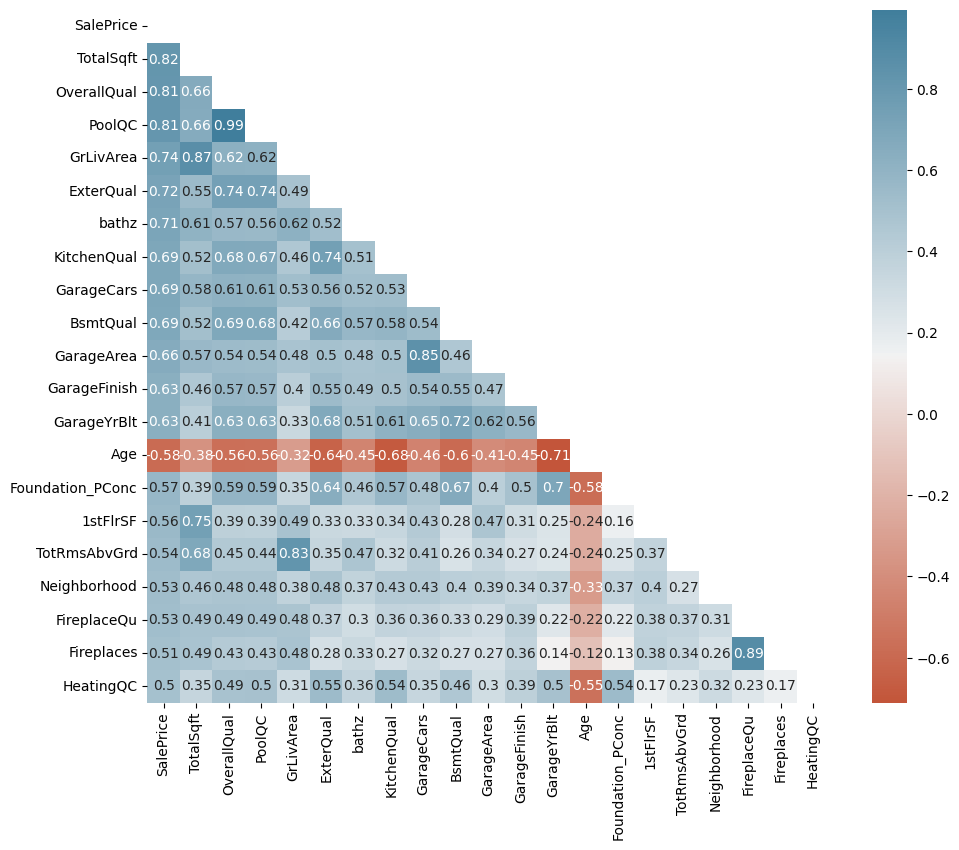

In [235]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

indicies = corr["SalePrice"][corr["SalePrice"].abs() > 0.5].sort_values(ascending=False, key=abs).index
high_corr = corr[corr["SalePrice"].abs() > 0.5][indicies].sort_values(ascending=False, key=abs, by="SalePrice")

plt.subplots(figsize=(11, 9))
sns.heatmap(high_corr,
    mask=np.triu(np.ones_like(high_corr, dtype=bool)),
    cmap=sns.diverging_palette(20, 230, as_cmap=True),
    annot=True,
)
None

# Fit, cross-validate, & compare

In [167]:
from xgboost import XGBRegressor
from sigfig import round
pretty = lambda x: round(str(x), decimals=2, spacer=",", spacing=3)
from sklearn.metrics import mean_absolute_error
from capture_output import Capturing
from random import shuffle

load_data()
for column_name, (transform, option) in transformations:
    full_data = transform(column_name, full_data, option)

outlier_ids = [523, 1298]
full_data = full_data.drop(outlier_ids).reset_index(drop=True)
full_price = full_price.drop(outlier_ids).reset_index(drop=True)
print(f"Dropped {len(original_data) - len(full_data)} rows")

def generate_cross_validation_sets(full_data, sets=5):
    indicies = [i for i in range(len(full_data))]
    shuffle(indicies)
    set_size = len(full_data) // sets
    for n in range(sets):
        yield indicies[n*set_size:(n+1)*set_size]

errors = []
iterations = []
for indicies_subset in generate_cross_validation_sets(full_data, sets=5):
    training___data = full_data.drop(indicies_subset)
    training___price = full_price.drop(indicies_subset)
    validation_data = full_data.iloc[indicies_subset]
    validation_price = full_price.iloc[indicies_subset]

    model = None
    model = XGBRegressor(n_estimators=1_000, learning_rate=0.05, early_stopping_rounds=5)
    with Capturing() as output:
        model.fit(training___data.drop("Id", axis=1), training___price, eval_set=[(validation_data.drop("Id", axis=1), validation_price)])

    predictions = model.predict(validation_data.drop("Id", axis=1))

    error = float(mean_absolute_error(validation_price, predictions))
    print(f"Error: {pretty(error)}", f"Iterations: {len(output)}")
    errors.append(error)
    iterations.append(len(output))

print(f"Mean Absolute Error: {pretty(mean(errors))}")
print(f"Optimal # Iterations(?): {mean(iterations)}")

Dropped 2 rows
Error: 16,546.44 Iterations: 188
Error: 15,387.70 Iterations: 151
Error: 15,131.99 Iterations: 156
Error: 14,615.77 Iterations: 210
Error: 15,518.72 Iterations: 100
Mean Absolute Error: 15,440.12
Optimal # Iterations(?): 161.0


## Saved results (with Random Forest model)

- Normie: Mean Absolute Error: 17787.279715068493: 16742.85882191781...19406.53876712329
- No Alley: Mean Absolute Error of 17652.627992694062: 16217.109150684932...19793.63994520548
- Basic zoning: Mean Absolute Error of 18059.097720547943: 16746.11709589041...19786.975287671234

# Generate Output

In [168]:
from xgboost import XGBRegressor

load_data()
manual_transformations()
for column_name, (transform, option) in transformations:
    full_data = transform(column_name, full_data, option)
    test_data = transform(column_name, test_data, option)

model = None
model = XGBRegressor(n_estimators=1_000, learning_rate=0.05)
model.fit(full_data.drop("Id", axis=1), full_price)

predictions = model.predict(test_data.drop("Id", axis=1))

submission = pd.DataFrame({'Id': test_data.index + 1461, 'SalePrice': predictions})
submission.to_csv('submission.csv', index=False)
submission

,Id,SalePrice
0,1461,113739.156250
1,1462,155514.890625
2,1463,185781.250000
3,1464,187920.468750
4,1465,189122.859375
...,...,...
1454,2915,76474.710938
1455,2916,78927.656250
1456,2917,158416.625000
1457,2918,120737.859375


In [169]:
# manual validation
from itertools import chain
# load_data()
m_fields = [g for g in test_data.keys() if "masonry" in g] + ["Id"]
# for id, row in chain(test_data[garage_fields].iterrows(), full_data[garage_fields].iterrows()):
#     if row.isnull().any():
#         if any([type(i) == str for i in row]) or any([i > 0 if type(i) in [float, int] and key != "Id" else False for key, i in row.items()]):
#             print(row)
Idz = [1670, 2320, 2453, 2611, 625, 689, 774, 1231, 1242, 1301, 1335]
output = pd.DataFrame(columns=full_data.keys())
for s3t in test_data, full_data:
    output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])
output[m_fields]
# full_data.drop("Id", axis=1).isnull().values.any()
output = pd.DataFrame(columns=full_data.keys())
for id, row in test_data.iterrows():
    if row.isnull().any():
        output = pd.concat([output, test_data[test_data["Id"] == row["Id"]]])
# test_data.isnull().any(axis=1).sum()
output

/tmp/ipykernel_2616/1064105884.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output = pd.concat([output, s3t[s3t["Id"].isin(Idz)]])


,Id,LotFrontage,LotArea,Street,LotShape,LandSlope,Neighborhood,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,MiscVal,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_20,MSSubClass_85,MSSubClass_90,MSSubClass_30,MSSubClass_160,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_180,MSSubClass_120,MSSubClass_60,MSSubClass_190,zoned_Floating Village Residential,zoned_Residential High Density,zoned_Residential Low Density,zoned_Residential Medium Density,LandContour_Low,LandContour_HLS,LandContour_Lvl,LandContour_Bnk,LotConfig_FR2,LotConfig_FR3,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Corner,Condition1_Norm,Condition1_PosN,Condition1_RRNn,Condition1_RRNe,Condition1_PosA,Condition1_RRAe,Condition1_Artery,Condition1_Feedr,Condition1_RRAn,Condition2_Norm,Condition2_PosN,Condition2_RRNn,Condition2_RRAn,Condition2_RRAe,Condition2_Artery,Condition2_Feedr,Condition2_PosA,BldgType_Duplex,BldgType_Twnhs,BldgType_2fmCon,BldgType_TwnhsE,BldgType_1Fam,HouseStyle_SLvl,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_2.5Unf,HouseStyle_SFoyer,HouseStyle_2Story,HouseStyle_2.5Fin,HouseStyle_1Story,RoofStyle_Gable,RoofStyle_Mansard,RoofStyle_Flat,RoofStyle_Hip,RoofStyle_Shed,RoofStyle_Gambrel,RoofMatl_WdShake,RoofMatl_Roll,RoofMatl_Membran,RoofMatl_CompShg,RoofMatl_ClyTile,RoofMatl_Tar&Grv,RoofMatl_Metal,RoofMatl_WdShngl,Exterior1st_CBlock,Exterior1st_Wd Sdng,Exterior1st_Stone,Exterior1st_HdBoard,Exterior1st_BrkFace,Exterior1st_CemntBd,Exterior1st_BrkComm,Exterior1st_MetalSd,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Plywood,Exterior1st_ImStucc,Exterior1st_WdShing,Exterior1st_AsphShn,Exterior1st_AsbShng,masonry Brick Common,masonry Brick Face,masonry Cinder Block,masonry Stone,masonry other,Foundation_Slab,Foundation_CBlock,Foundation_Wood,Foundation_Stone,Foundation_BrkTil,Foundation_PConc,basement Good Living Quarters sqft,basement Average Living Quarters sqft,basement Below Average Living Quarters sqft,basement Average Rec Room sqft,basement Low Quality sqft,basement Unfinished sqft,bathz,Heating_Wall,Heating_OthW,Heating_Grav,Heating_GasA,Heating_Floor,Heating_GasW,GarageType_BuiltIn,GarageType_Detchd,GarageType_CarPort,GarageType_Basment,GarageType_2Types,GarageType_Attchd,Fence_MnPrv,Fence_MnWw,Fence_GdPrv,Fence_nan,Fence_GdWo,SaleType_ConLI,SaleType_WD,SaleType_New,SaleType_Con,SaleType_COD,SaleType_Oth,SaleType_CWD,SaleType_ConLw,SaleType_ConLD,SaleCondition_Alloca,SaleCondition_AdjLand,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_Family,SaleCondition_Abnorml,Age,IsNew,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,MoSold_1,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,TotalSqft
